**Завдання:**

Використовуючи датасет з файлу cardox.scv (об'єми продажів мережі супермаркетів) виконайте наступну роботу:

1. Проведіть попередній аналіз даних.
2. Скорегуйте виявлені аномалії.
3. Проведіть необхідні попередні підготовки даних (декомпозиція, коригування ряду, заповнення пропущених значень і тд.)
4. Оберіть модель і проведіть оцінку її метрик.
5. Проведіть кінцеву діагностику для отриманої моделі.
6. Виконайте прогноз на 30 років.
7. Збережіть результат прогнозування у файл.

In [1]:
import pandas as pd
import numpy as np
from pandas.plotting import scatter_matrix
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import ThresholdAD
from adtk.detector import OutlierDetector

from sklearn.neighbors import LocalOutlierFactor
from scipy.stats import variation
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from itertools import compress, product

from pmdarima import auto_arima

import warnings
warnings.filterwarnings("ignore")

df = pd.read_csv('cardox.csv')

print(f"Датасет має наступні розміри: {df.shape}\n")
print("Приклад датасету:\n")
display(df.head(10))

Датасет має наступні розміри: (729, 2)

Приклад датасету:



,date,value
0,1958-03-01,315.71
1,1958-04-01,317.45
2,1958-05-01,317.50
3,1958-06-01,317.10
4,1958-07-01,315.86
5,1958-08-01,314.93
6,1958-09-01,313.20
7,1958-10-01,312.66
8,1958-11-01,313.33
9,1958-12-01,314.67


In [2]:
display(df.describe())

,value
count,729.000000
mean,353.787229
std,27.547500
min,312.660000
25%,328.570000
50%,351.410000
75%,375.990000
max,411.240000


In [3]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    729 non-null    object 
 1   value   729 non-null    float64
dtypes: float64(1), object(1)
memory usage: 11.5+ KB


None

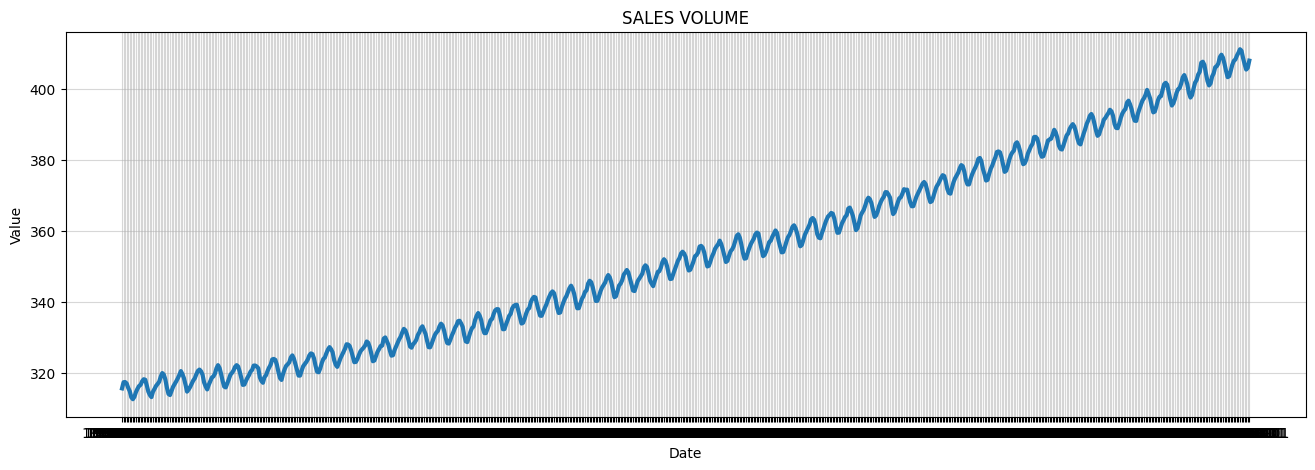

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 5))
plt.plot(df['date'], df['value'], linewidth=3)
plt.title("SALES VOLUME")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(axis='y', alpha=0.5)
plt.grid(axis='x', alpha=0.5)

plt.show()

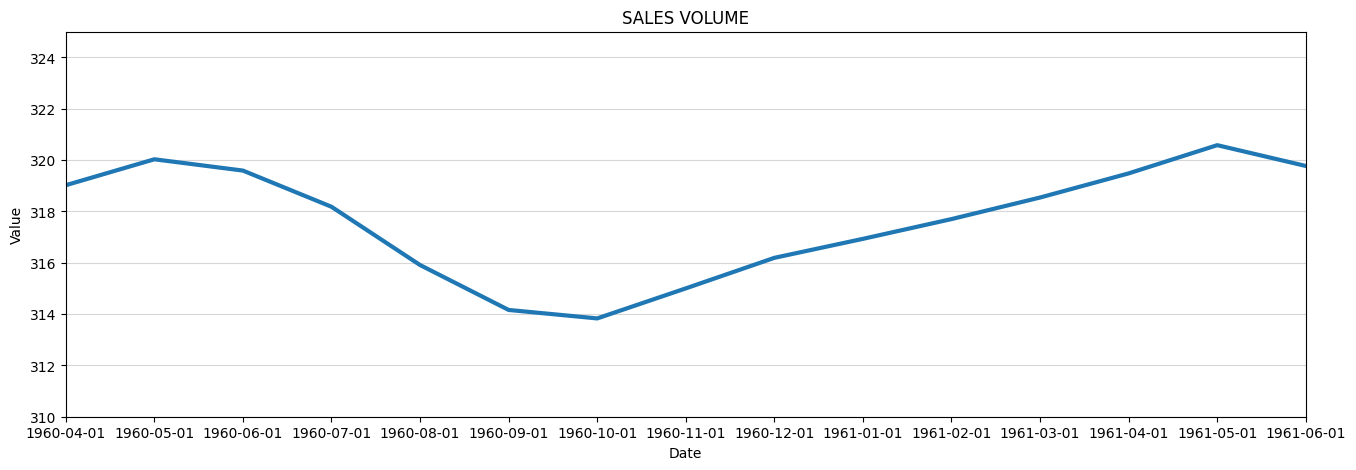

In [5]:
plt.figure(figsize=(16, 5))
plt.plot(df['date'], df['value'], linewidth=3)
plt.title("SALES VOLUME")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(axis='y', alpha=0.5)
plt.xlim("1960-04-01", "1961-06-01")
plt.ylim(310, 325)

plt.show()

**Аналізуючи дані графіки можна зробити висновки про наявність трендовості та циклічності в даному часовому та відсутність 
екзогенних регресорів.**

[<AxesSubplot: >]

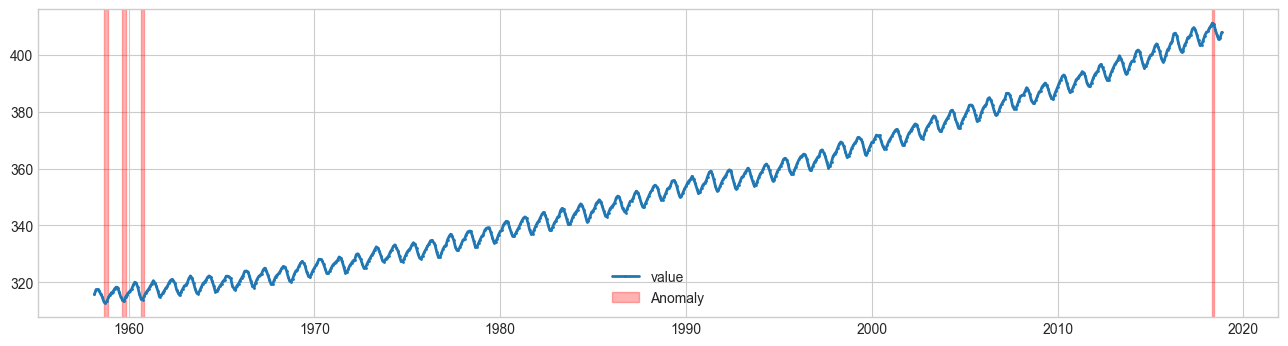

In [6]:
df.set_index('date', inplace=True)
df.index = pd.to_datetime(df.index)

df = validate_series(df)

outlier_detector = OutlierDetector(LocalOutlierFactor(contamination=0.01))
anomalies = outlier_detector.fit_detect(df)
plot(df, anomaly=anomalies, ts_linewidth=2, anomaly_color='red', anomaly_alpha=0.3, curve_group='all')



In [7]:
anomalies[anomalies]

date
1958-09-01    True
1958-10-01    True
1958-11-01    True
1959-09-01    True
1959-10-01    True
1960-09-01    True
1960-10-01    True
2018-05-01    True
dtype: bool

**З графіка вище можна зробити висновок про відсутність необхідності кореляції аномалій.**

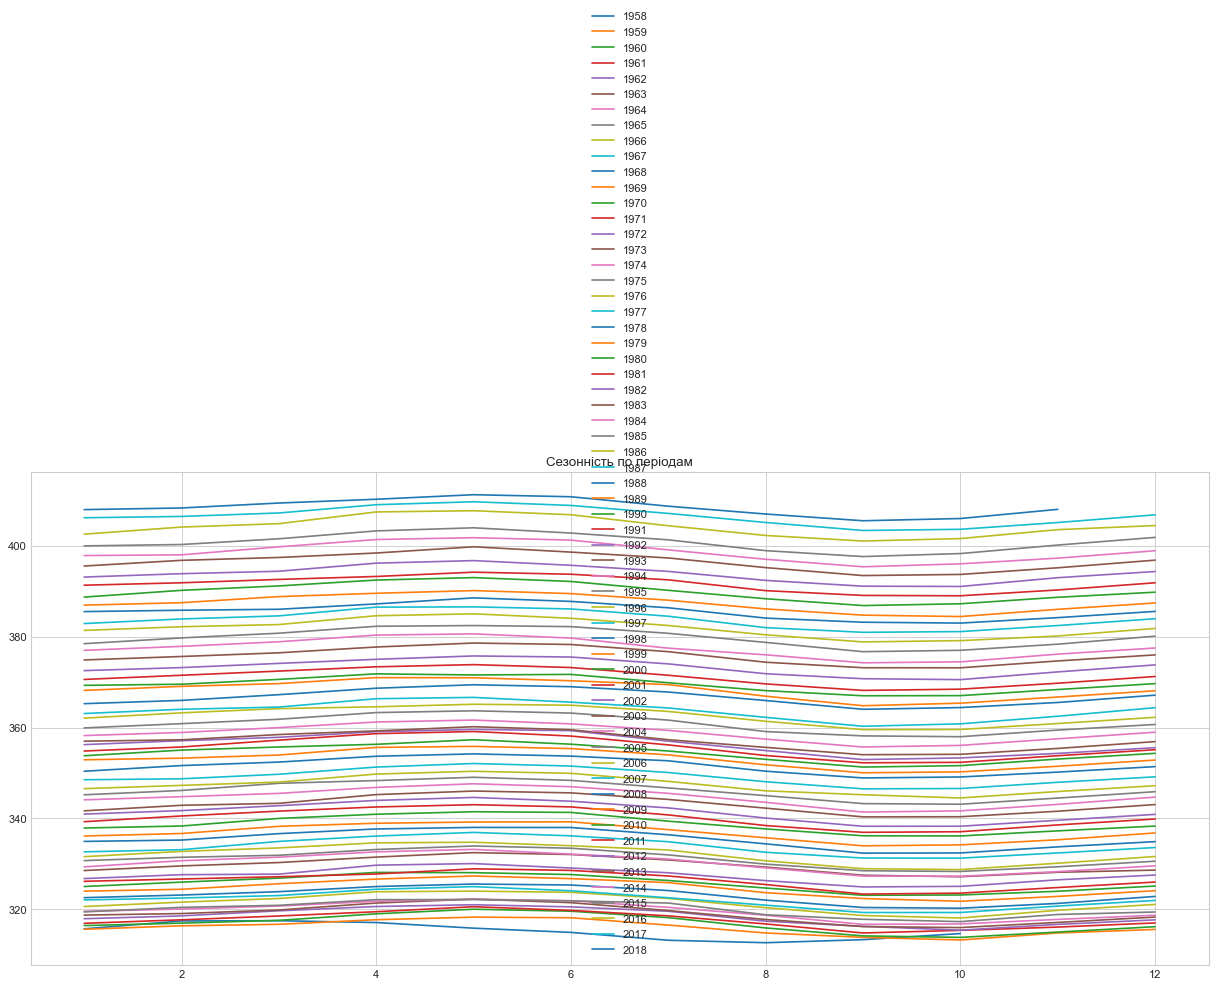

In [8]:
def sesonal(data, s):
    plt.figure(figsize=(19,8), dpi= 80)
    for i, y in enumerate(data.index.year.unique()):
        plt.plot(list(range(1,len(data[data.index.year==y])+1)), data[data.index.year==y][data.columns[0]].values, label=y)
    plt.title("Сезонність по періодам")
    plt.legend(loc="best")
    plt.show()

sesonal(df, 12)

Text(0.5, 1.05, 'Additive-increasing model')

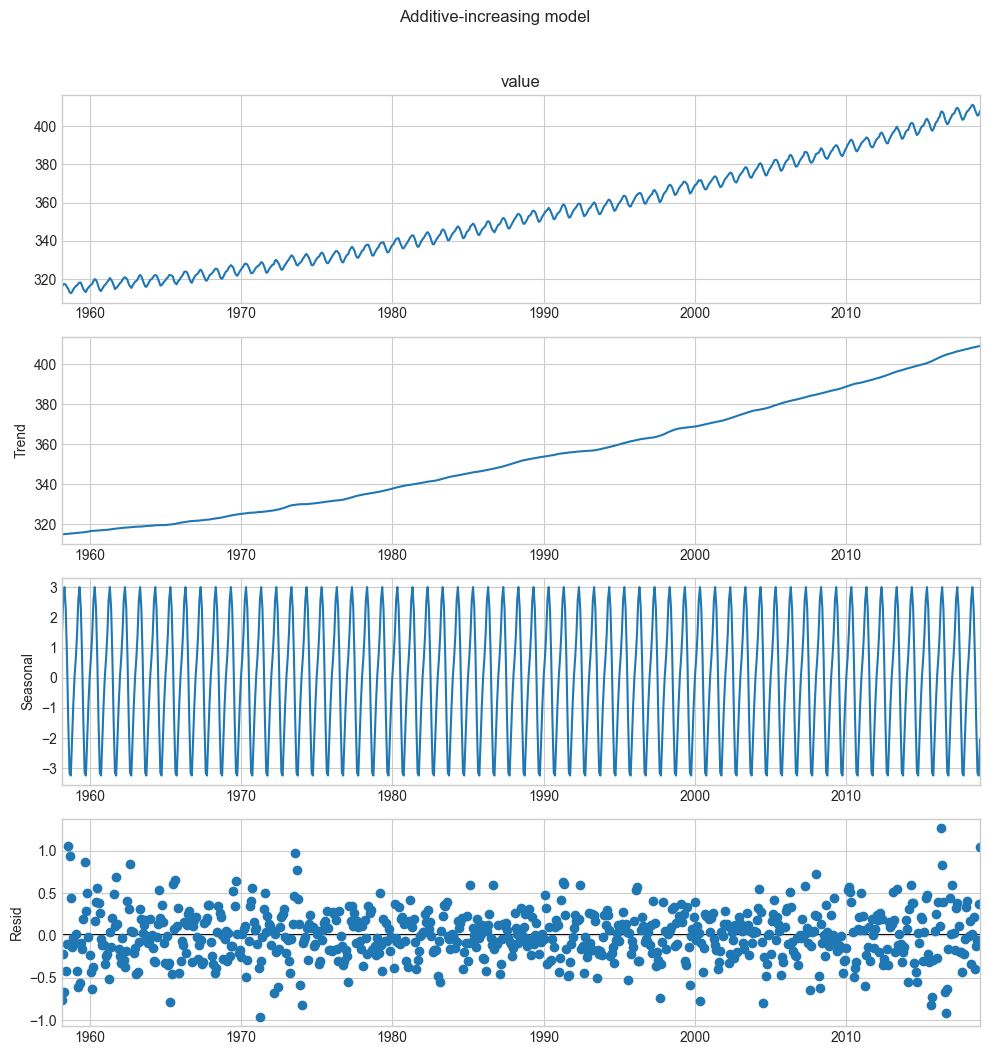

In [9]:
result_A = seasonal_decompose(df.value, model='additive-increasing', extrapolate_trend=12)


plt.rcParams.update({'figure.figsize': (10,10)})
result_A.plot().suptitle('Additive-increasing model', y=1.05)

**З даних графіків підтвержуємо велике значення тренду та сезонності для даного часового ряду. Залишкові складові графіка мають хаотичнкий та непередбачуваний характер. Для прогнозування даного часового ряду підійдуть наступні моделі: SARIMA, SARIMAX, HWES.**

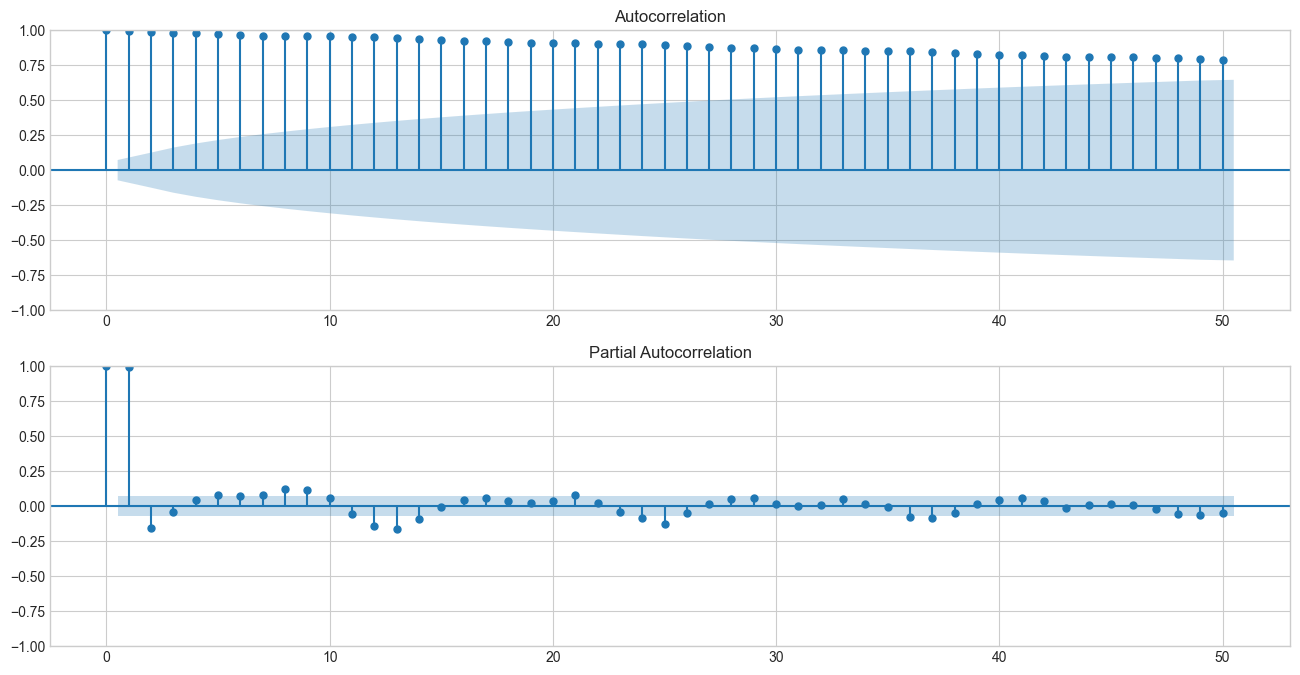

In [10]:
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['value'].values.squeeze(), lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['value'], lags=50, ax=ax2)

**З графіків ACF та PACF можемо зробити висновок про сильну автокореляцію даних, що підтвержує наявність тренду та сезонності.**

Розіб'ємо датасет на тренуючу та тестову вибірки.

In [11]:
df_train = df[:'2010']
df_test = df['2011':]

In [13]:
model = auto_arima(df_train, seasonal=True, m=12, trace=True, suppress_warnings=True, error_action='ignore')
model

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=400.702, Time=3.04 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2040.995, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.95 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1360.042, Time=0.72 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2044.895, Time=0.04 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=inf, Time=2.94 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=639.334, Time=5.45 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=428.618, Time=7.80 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=444.125, Time=6.94 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=1209.925, Time=0.80 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=inf, Time=6.49 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=508.676, Time=7.34 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=411.817, Time=8.82 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=393.111, Time=2.64 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : AI

ARIMA(order=(1, 1, 1), scoring_args={}, seasonal_order=(2, 0, 2, 12),
      suppress_warnings=True)

In [14]:
mod = sm.tsa.statespace.SARIMAX(df_train, order=(1, 1, 1), seasonal_order=(2, 0, 2, 12))
results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2344      0.038      6.102      0.000       0.159       0.310
ma.L1         -0.5701      0.045    -12.598      0.000      -0.659      -0.481
ar.S.L12       0.0693      0.029      2.360      0.018       0.012       0.127
ar.S.L24       0.9302      0.029     31.612      0.000       0.873       0.988
ma.S.L12       0.0778      0.028      2.781      0.005       0.023       0.133
ma.S.L24      -0.8469      0.030    -28.214      0.000      -0.906      -0.788
sigma2         0.0898      0.005     17.801      0.000       0.080       0.100


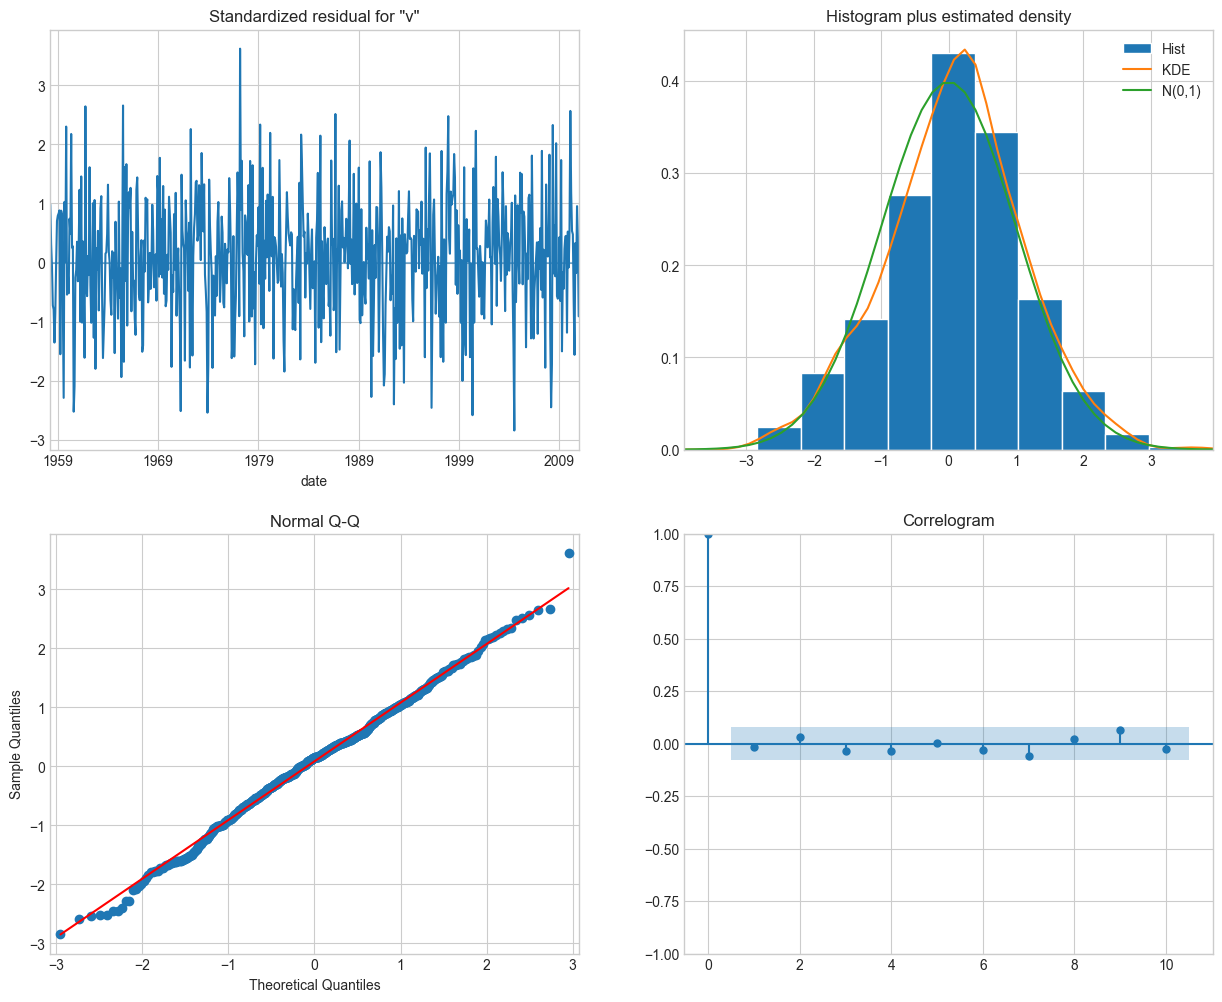

In [15]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

**Аналізуючі дані графіки можна зробити наступні висновки:**

1. Залишки моделі (різниця між реальними даними і даними, що прогнозуються) мають не систематичний характер.
2. Гістограма залишків має нормальний розподіл.
3. Підтвердження нормального росподілення залишків моделі по графіку Normal Q-Q.

**В результаті робимо висновок про досить якісний вибір моделі SARIMA та автоматично підібрані параметри ARIMA моделі.**

In [25]:
predict=results.get_prediction()
predict.predicted_mean

date
1958-03-01      0.000000
1958-04-01    315.709727
1958-05-01    316.971377
1958-06-01    317.220416
1958-07-01    317.074152
                 ...    
2010-08-01    388.250854
2010-09-01    386.903156
2010-10-01    386.954006
2010-11-01    388.542265
2010-12-01    390.062684
Freq: MS, Name: predicted_mean, Length: 634, dtype: float64

In [34]:
def metrics(real, forecast):
    
    if type(real)==pd.core.frame.DataFrame:
        real=real[real.columns[0]].values
    
    print("Тест на стаціонарність:")
    dftest = adfuller(real-forecast, autolag='AIC')
    print("\tT-статистика = {:.3f}".format(dftest[0]))
    print("\tP-значення = {:.3f}".format(dftest[1]))
    print("Критичне значення :")
    for k, v in dftest[4].items():
        print("\t{}: {} - Дані {} стационарні з ймовірністю {}% відсотків".format(k, v, "не" if v<dftest[0] else "", 100-int(k[:-1])))
    
    forecast=np.array(forecast)
    print('MAD:', round(abs(real-forecast).mean(),4))
    print('MSE:', round(((real-forecast)**2).mean(),4))
    print('MAPE:', round((abs(real-forecast)/real).mean(),4))
    print('MPE:', round(((real-forecast)/real).mean(),4))
    print('Стандартна похибка:', round(((real-forecast)**2).mean()**0.5,4)) 






test_prediction = results.get_prediction(start='2011', end='2018-11-01')
metrics(df_test, test_prediction.predicted_mean)

Тест на стаціонарність:
	T-статистика = -0.424
	P-значення = 0.906
Критичне значення :
	1%: -3.505190196159122 - Дані не стационарні з ймовірністю 99% відсотків
	5%: -2.894232085048011 - Дані не стационарні з ймовірністю 95% відсотків
	10%: -2.5842101234567902 - Дані не стационарні з ймовірністю 90% відсотків
MAD: 1.7139
MSE: 4.6012
MAPE: 0.0042
MPE: 0.0041
Стандартна похибка: 2.1451


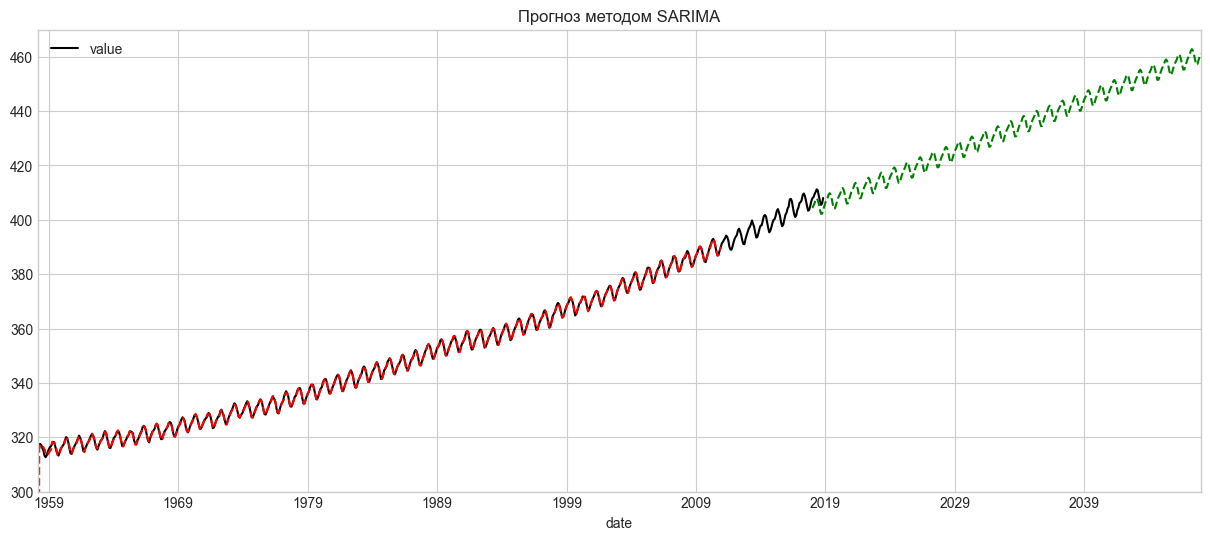

In [48]:
predict_data = results.get_prediction(start='2018', end='2048')


ax = df.plot(figsize=(15,6), color='black', title="Прогноз методом SARIMA" )
results.fittedvalues.plot(ax=ax, style='--', color='red')
predict_data.predicted_mean.plot(ax=ax, style='--', color='green')
plt.ylim(300, 470)
plt.show()

**Модель показує досить непогані результати, з урахуванням того, що прогнозування виконувалося без залучення тестової вибірки, яка складає 13% від всього датасету. Для більш точного прогнозування, зробимо проноз, спираючись на повний датасет.**

In [39]:
model_ful = sm.tsa.statespace.SARIMAX(df, order=(1, 1, 1), seasonal_order=(2, 0, 2, 12))
results_ful = model_ful.fit()

In [40]:
predict_data_full = results_ful.get_prediction(start='2018', end='2048')

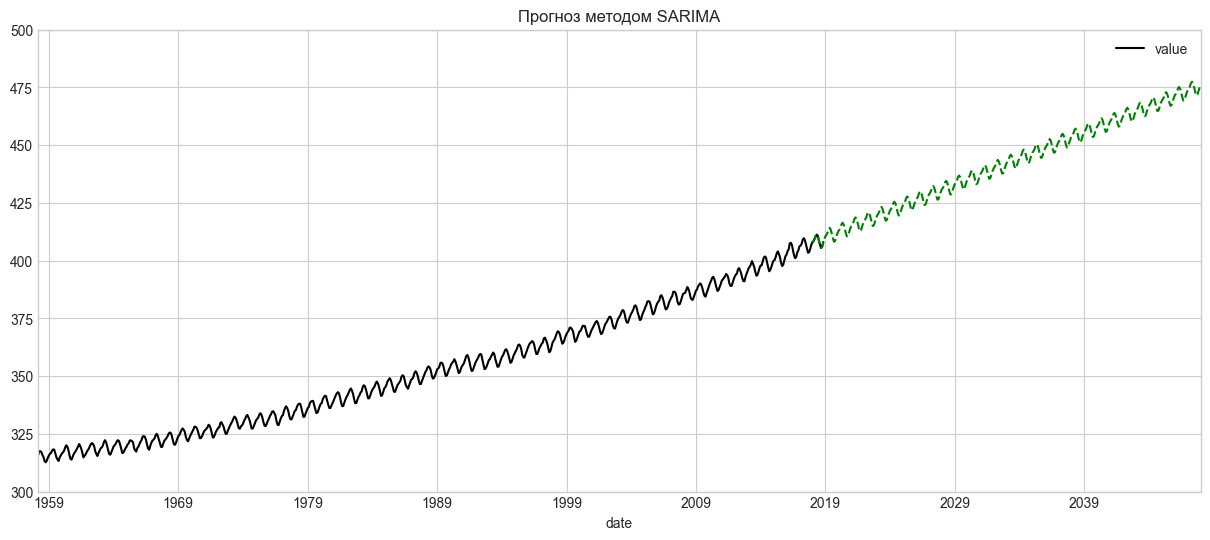

In [42]:
ax = df.plot(figsize=(15,6), color='black', title="Прогноз методом SARIMA" )
predict_data_full.predicted_mean.plot(ax=ax, style='--', color='green')
plt.ylim(300, 500)
plt.show()

In [56]:
df_predict = pd.DataFrame(data = predict_data_full.predicted_mean)
df_predict.to_csv('predict_data.csv', encoding='utf-8')